In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from scipy.stats import multivariate_normal, entropy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

np.random.seed(0)

In [2]:
def accuracy(true_labels, predicted_labels):
    cont_matrix = contingency_matrix(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(cont_matrix, maximize = True)
    accuracy = cont_matrix[row_ind, col_ind].sum() / len(true_labels)
    
    return accuracy

# Part (a)

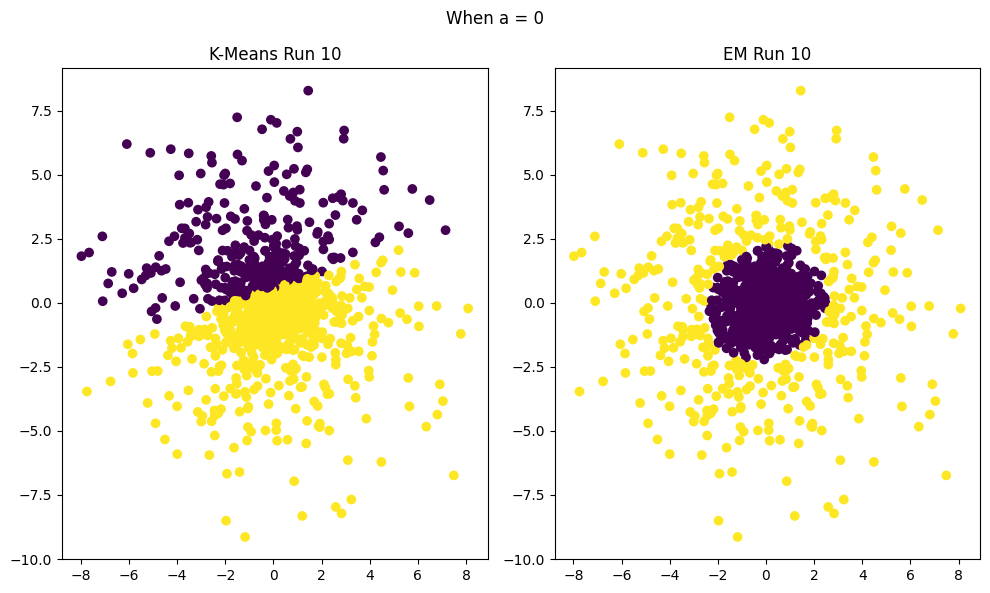

In [3]:
Xq = np.random.normal(loc= 0, scale= 3, size= (500, 2))
y = np.zeros(500)

accuracy_kmeans = []
ari_kmeans = []
accuracy_em = []
ari_em = []

for a in range(5):
    Xa = np.random.multivariate_normal(mean= np.array([a, 0]), cov= np.eye(2), size= 500)
    y_a = np.ones(500)

    X = np.vstack((Xa, Xq))
    true_labels = np.concatenate((np.ones(500), np.zeros(500)))

    em_clusters = []
    kmeans_clusters = []

    for i in range(10):
        kmeans = KMeans(n_clusters=2, random_state=i)
        kmeans.fit(X)
        kmeans_clusters.append(kmeans.labels_)

        em = GaussianMixture(n_components=2, covariance_type='full', random_state=i, init_params = 'random')
        em.fit(X)
        em_clusters.append(em.predict(X))

        accuracyk = accuracy(true_labels, kmeans_clusters[i])
        arik = adjusted_rand_score(true_labels, kmeans_clusters[i])

        accuracyem = accuracy(true_labels, em_clusters[i])
        ariem = adjusted_rand_score(true_labels, em_clusters[i])
        #if i == 0:
        #    print('a = {}'.format(a))

        #print('Kmeans Accuracy Run {}, a = {}:'.format(i + 1, a), '{}'.format(accuracyk) + ',', 'ARI: ', arik)


        #print('EM Accuracy Run {}, a = {}:'.format(i + 1, a), '{}'.format(accuracyem) + ',', 'ARI: ', ariem)
        #print('\n')
        
        accuracy_kmeans.append(accuracyk)
        ari_kmeans.append(arik)
        accuracy_em.append(accuracyem)
        ari_em.append(ariem)

        if a == 0 and i == 9:
            plt.figure(figsize=(10, 6))

            plt.subplot(1, 2, 1)
            plt.scatter(X[:, 0], X[:, 1], c = kmeans_clusters[0])
            plt.title("K-Means Run {}".format(i+1))

            plt.subplot(1, 2, 2)
            plt.scatter(X[:, 0], X[:, 1], c = em_clusters[0])
            plt.title("EM Run {}".format(i+1))
            plt.suptitle('When a = {}'.format(a))
            plt.tight_layout()
            plt.show()

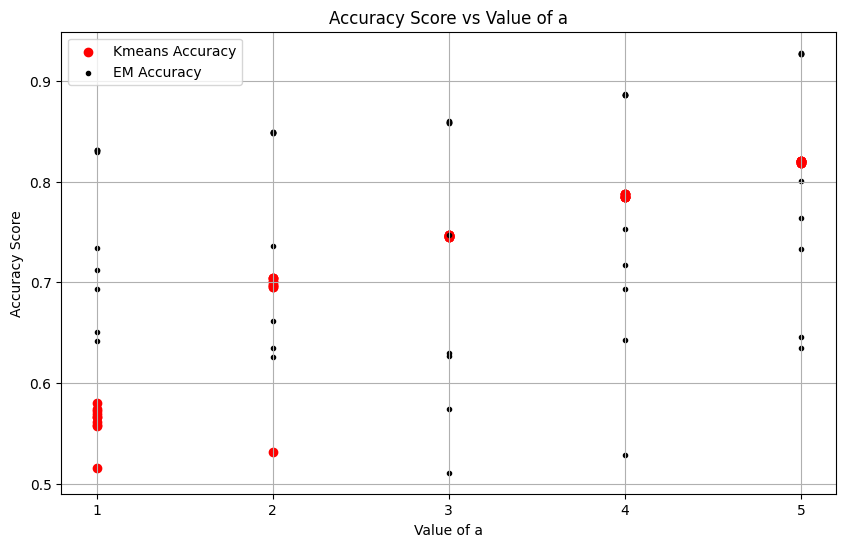

In [4]:
plt.figure(figsize = (10,6))
plt.scatter(np.repeat(np.arange(1, 6), 10), accuracy_kmeans, color = 'red', label = 'Kmeans Accuracy')
plt.scatter(np.repeat(np.arange(1, 6), 10), accuracy_em, color = 'black', label = 'EM Accuracy', marker = '.')
plt.xlabel('Value of a')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Value of a')
plt.xticks([1,2,3,4,5])
plt.grid()
plt.legend()
plt.show()

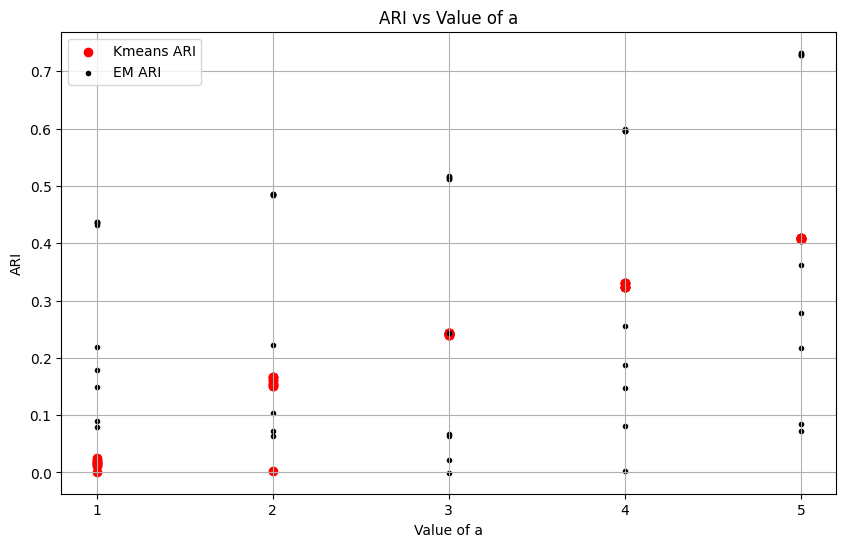

In [5]:
plt.figure(figsize = (10,6))
plt.scatter(np.repeat(np.arange(1, 6), 10), ari_kmeans, color = 'red', label = 'Kmeans ARI')
plt.scatter(np.repeat(np.arange(1, 6), 10), ari_em, color = 'black', label = 'EM ARI',  marker = '.')
#plt.ylim((0, 1))
plt.xlabel('Value of a')
plt.ylabel('ARI')
plt.title('ARI vs Value of a')
plt.xticks([1,2,3,4,5])
plt.grid()
plt.legend()
plt.show()

# Part (b)

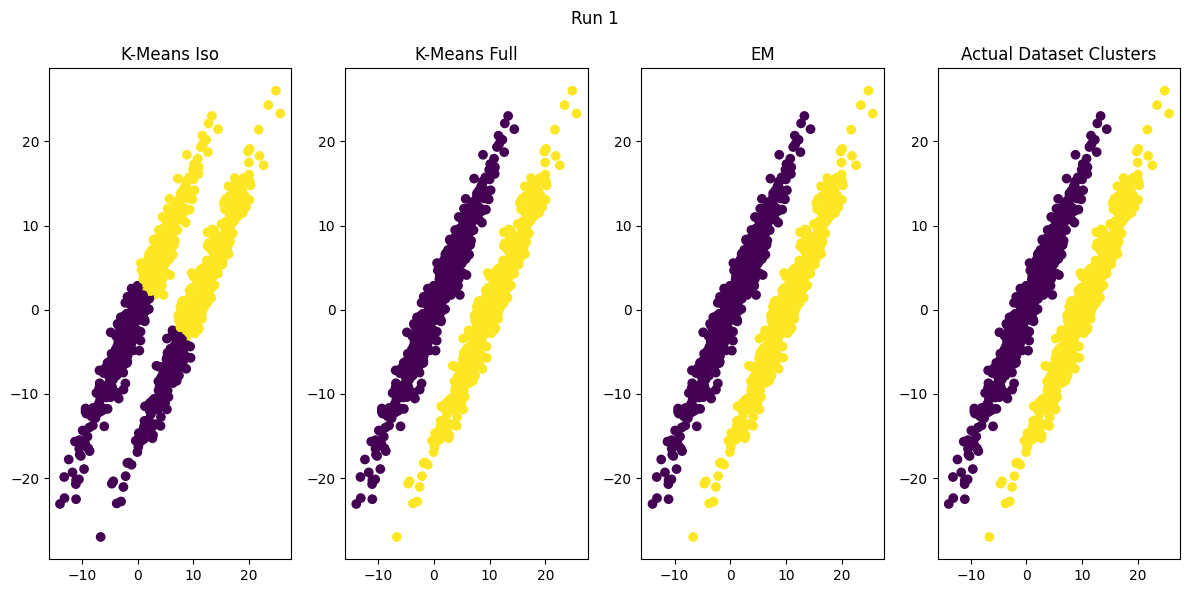

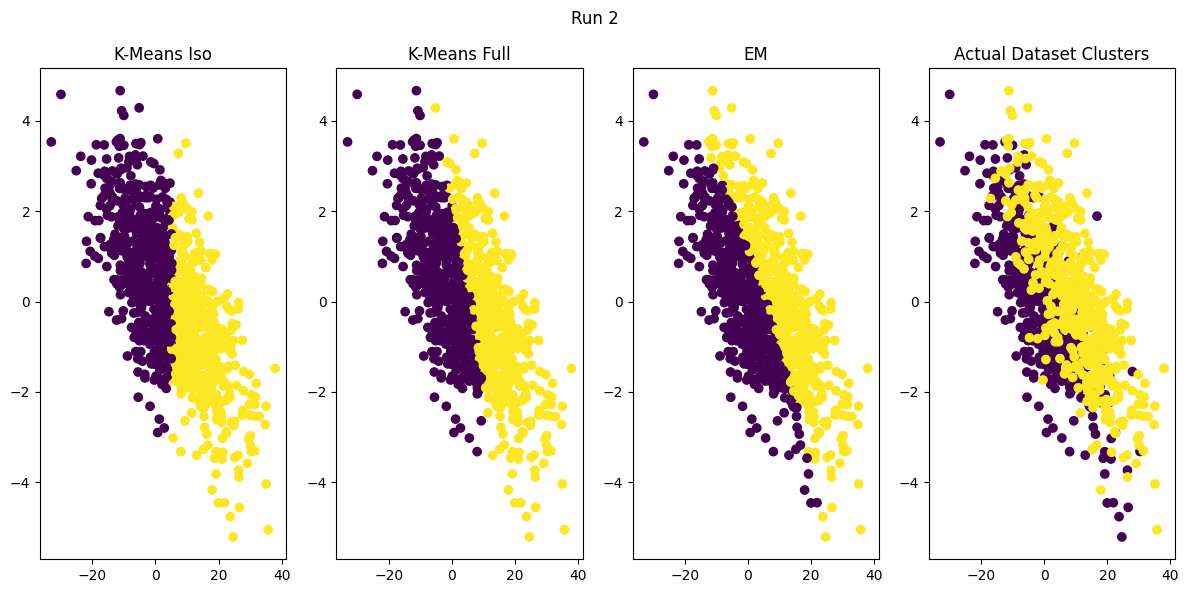

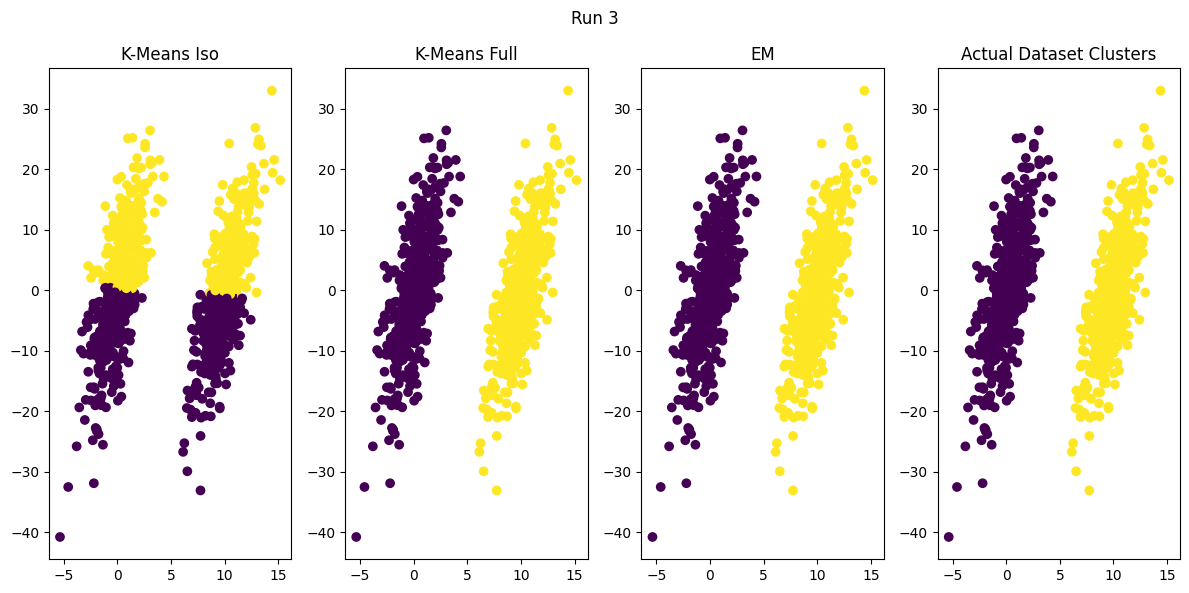

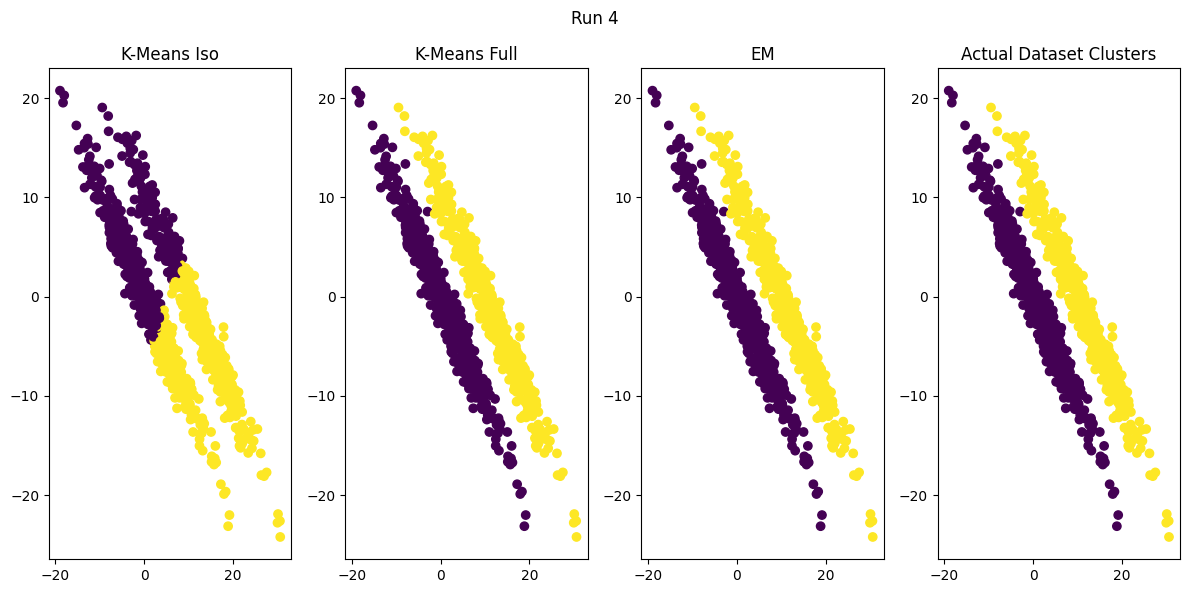

In [6]:
kldiv = []
kmeans_iso_acc = []
kmeans_full_acc = []
em_acc = []
ari_k_iso = []
ari_k_full = []
ari_em = []

for i in range(10):
    np.random.seed(i)

    M = np.random.normal(0, 1, size=(2, 2))
    U, _, _ = svd(M)
    sigma = U.dot(np.diag([100, 1])).dot(U.T)

    Xq = multivariate_normal.rvs(mean= [0, 0], cov= sigma, size= 500)
    Xp = multivariate_normal.rvs(mean= [10, 0], cov= sigma, size= 500)

    KL_divergence = entropy(
        multivariate_normal.pdf(Xq, mean= [0, 0], cov= sigma), 
        multivariate_normal.pdf(Xp, mean= [10, 0], cov= sigma)
    )
    kldiv.append(KL_divergence)

    X = np.concatenate((Xq, Xp))
    true_labels = np.concatenate((np.zeros(Xq.shape[0]), np.ones(Xp.shape[0])))

#kmeans iso
    kmeans_isotropic = GaussianMixture(n_components=2, covariance_type='spherical', init_params='kmeans', means_init = [[0,0],[10,0]])
    kmeans_isotropic.fit(X)
    labels= kmeans_isotropic.predict(X)
    acc = accuracy(true_labels, labels)
    ari = adjusted_rand_score(true_labels, labels)
    kmeans_iso_acc.append(acc)
    ari_k_iso.append(ari)
    if i in [0,1,2,3]:
        plt.figure(figsize=(12, 6))
        plt.subplot(1,4,1)
        plt.scatter(X[:, 0], X[:, 1], c=labels)
        plt.title("K-Means Iso")



#kmeans full
    kmeans_full = GaussianMixture(n_components=2, means_init = [[0,0],[10,0]])
    kmeans_full.fit(X)
    labels = kmeans_full.predict(X)
    acc = accuracy(true_labels, labels)
    ari = adjusted_rand_score(true_labels, labels)
    kmeans_full_acc.append(acc)
    ari_k_full.append(ari)
    if i in [0,1,2,3]:
        plt.subplot(1,4,2)
        plt.scatter(X[:, 0], X[:, 1], c=labels)
        plt.title("K-Means Full")


#em
    em = GaussianMixture(n_components=2, init_params='random', means_init = [[0,0],[10,0]])
    em.fit(X)
    labels= em.predict(X)
    acc = accuracy(true_labels, labels)
    ari = adjusted_rand_score(true_labels, labels)
    em_acc.append(acc)
    ari_em.append(ari)
    if i in [0,1,2,3]:
        plt.subplot(1,4,3)
        plt.scatter(X[:, 0], X[:, 1], c=labels)
        plt.title("EM")
        plt.suptitle("Run {}".format(i+1))

        plt.subplot(1,4,4)
        plt.scatter(X[:, 0], X[:, 1], c=true_labels)
        plt.title('Actual Dataset Clusters')

        plt.tight_layout()
        plt.show()



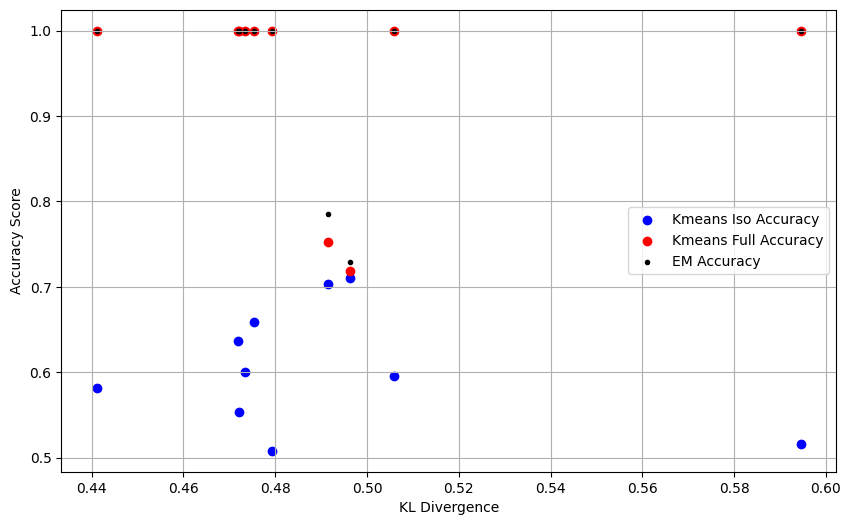

In [7]:
plt.figure(figsize = (10,6))
plt.scatter(kldiv, kmeans_iso_acc, color = 'blue', label = 'Kmeans Iso Accuracy')
plt.scatter(kldiv, kmeans_full_acc, color = 'red', label = 'Kmeans Full Accuracy', marker = 'o')
plt.scatter(kldiv, em_acc, color = 'black', label = 'EM Accuracy', marker = '.')
plt.xlabel('KL Divergence')
plt.ylabel('Accuracy Score')
plt.grid()
plt.legend()
plt.show()

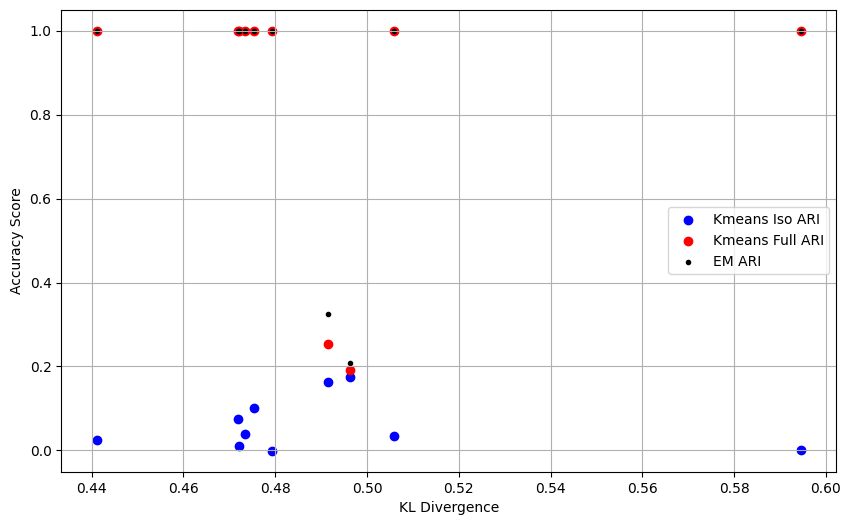

In [8]:
plt.figure(figsize = (10,6))
plt.scatter(kldiv, ari_k_iso, color = 'blue', label = 'Kmeans Iso ARI')
plt.scatter(kldiv, ari_k_full, color = 'red', label = 'Kmeans Full ARI', marker = 'o')
plt.scatter(kldiv, ari_em, color = 'black', label = 'EM ARI', marker = '.')
plt.xlabel('KL Divergence')
plt.ylabel('Accuracy Score')
plt.grid()
plt.legend()
plt.show()